[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on LaTeX OCR Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `A100 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sun Dec  8 07:15:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [ ]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.4 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("unsloth-latex-ocr")
version = project.version(1)
dataset = version.download("jsonl")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to unsloth-latex-ocr-1 in jsonl:: 100%|██████████| 13981/13981 [00:01<00:00, 9656.00it/s] 


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"602d220b909f4973426fefbf6999e4cc_png.rf.acd4eada696860173db01f9716dacb7f.jpg","prefix":"read in latex","suffix":"\\left( \\alpha ( P ^ { 2 } + m ^ { 2 } ) + \\varepsilon m ( P J - \\varepsilon \\alpha m ) \\right) \\Psi = 0 ,"}
{"image":"880b59a23ee60a1a87fa42d15fd74c22_png.rf.acf3b6961a42e92d466a5b0eecefffcc.jpg","prefix":"read in latex","suffix":"\\vec { d } _ { e } \\cdot \\vec { d } _ { e } = \\vec { d } _ { m } \\cdot \\vec { d } _ { m } = 8 \\frac { 1 + b \\chi + \\chi ^ { 2 } } { 4 - b ^ { 2 } }"}
{"image":"c7b26159b532e5a3d3bd60e1dccd975c_png.rf.acdf8492321cdda95f97fa49fdd915c5.jpg","prefix":"read in latex","suffix":"( g f ) ( x ) \\doteq f ( g ^ { - 1 } x ) ,"}
{"image":"af3f191888dc917814619c1638e01f4a_png.rf.acd914b506089c2658490414f0611b39.jpg","prefix":"read in latex","suffix":"\\mu _ { 0 } = \\frac { \\pi m _ { V } ^ { 2 } } { 2 e ^ { 2 } } \\int _ { 0 } ^ { \\infty } d u \\frac { e ^ { - u } } { u + \\frac { m _ { V } ^ { 2 } } { 2 \\Lambda ^ { 2 } } } ,"}
{"im

In [ ]:
!wc -l < {dataset.location}/train/annotations.jsonl
!wc -l < {dataset.location}/valid/annotations.jsonl
!wc -l < {dataset.location}/test/annotations.jsonl

9992
1992
1999


### Set up and test data loaders

In [ ]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [ ]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/train/annotations.jsonl",
    image_directory_path=f"{dataset.location}/train",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path=f"{dataset.location}/valid",
)
test_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/test/annotations.jsonl",
    image_directory_path=f"{dataset.location}/test",
)

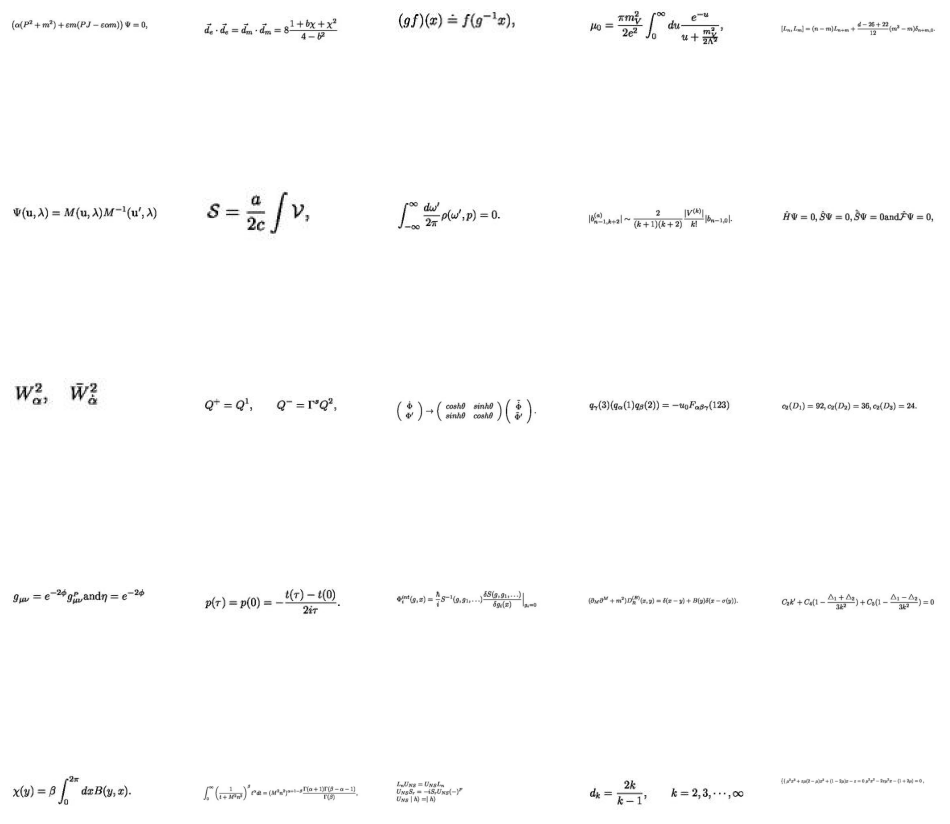

In [ ]:
from tqdm import tqdm
import supervision as sv


images = []
for i in range(25):
    image, label = train_dataset[i]
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the accuracy of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [ ]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-448"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [ ]:
# @title Freeze the image encoder

# TORCH_DTYPE = torch.bfloat16

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

In [ ]:
# @title Fine-tune the entire model with LoRA and QLoRA

from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


### Fine-tune PaliGemma2 on LaTeX OCR dataset

In [ ]:
from transformers import Trainer, TrainingArguments


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [label["suffix"] for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=4,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=200,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="paligemma2_latex_ocr",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [ ]:
trainer.train()

### Run inference with fine-tuned PaliGemma2 model

In [30]:
# @title Function to render text diffs

from difflib import SequenceMatcher
from IPython.core.display import display, HTML

def side_by_side_diff_divs(text1, text2):
    lines1 = text1.splitlines()
    lines2 = text2.splitlines()

    original_output = []
    modified_output = []

    for line1, line2 in zip(lines1, lines2):
        words1 = line1.split()
        words2 = line2.split()

        matcher = SequenceMatcher(None, words1, words2)

        original_line = []
        modified_line = []

        for tag, i1, i2, j1, j2 in matcher.get_opcodes():
            if tag == 'replace':
                original_line.append(f"<span class='diff-remove'>{' '.join(words1[i1:i2])}</span>")
                modified_line.append(f"<span class='diff-add'>{' '.join(words2[j1:j2])}</span>")
            elif tag == 'delete':
                original_line.append(f"<span class='diff-remove'>{' '.join(words1[i1:i2])}</span>")
            elif tag == 'insert':
                modified_line.append(f"<span class='diff-add'>{' '.join(words2[j1:j2])}</span>")
            elif tag == 'equal':
                original_line.append(' '.join(words1[i1:i2]))
                modified_line.append(' '.join(words2[j1:j2]))

        original_output.append(' '.join(original_line) + "<br>")
        modified_output.append(' '.join(modified_line) + "<br>")

    original_html = "<br>" + ''.join(original_output) + "<br>"
    modified_html = "<br>" + ''.join(modified_output) + "<br>"

    html = f"""
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 0; padding: 0; }}
            .container {{ display: flex; align-items: flex-start; }}
            .column {{
                flex: 1;
                padding: 10px;
                white-space: pre-wrap;
                text-align: left;
            }}
            .diff-remove {{
                background-color: #d9534f;  /* Dark red */
                color: white;
                text-decoration: line-through;
                border-radius: 4px;
                padding: 2px 4px;
            }}
            .diff-add {{
                background-color: #5cb85c;  /* Dark green */
                color: white;
                border-radius: 4px;
                padding: 2px 4px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="column" style="border-right: 1px solid #ccc;">
                {original_html}
            </div>
            <div class="column">
                {modified_html}
            </div>
        </div>
    </body>
    </html>
    """
    return html

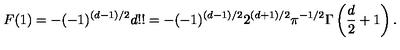

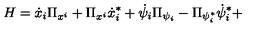

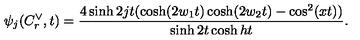

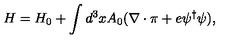

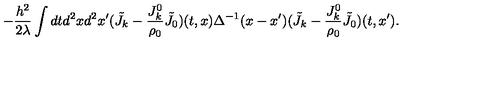

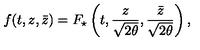

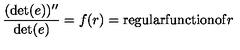

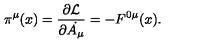

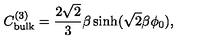

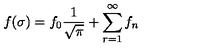

In [28]:
# @title Suffix vs. generated text

for i in range (10):
    image, label = test_dataset[i]
    prefix = "<image>" + label["prefix"]
    suffix = label["suffix"]

    inputs = processor(
        text=prefix,
        images=image,
        return_tensors="pt"
    ).to(TORCH_DTYPE).to(DEVICE)

    prefix_length = inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False, num_beams=3)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

    html_diff = side_by_side_diff_divs(suffix, generated_text)
    display(image)
    display(HTML(html_diff))

### Evaluate fine-tuned PaliGemma2 model

In [29]:
import numpy as np

targets = []
predictions = []

with torch.inference_mode():
    for i in range(10):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False, num_beams=3)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        targets.append(suffix)
        predictions.append(generated_text)

**NOTE:** BLEU (Bilingual Evaluation Understudy) is a metric used to measure the similarity between a VLM's generated text (like a caption for an image) and a human-written reference text. It works by calculating the overlap of words and phrases, giving a score between 0 and 1.  A higher BLEU score indicates better agreement between the generated text and the reference, meaning the VLM is doing a better job of producing expected output.

In [31]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [32]:
# @title Calculate BLEU

from evaluate import load

bleu = load("bleu")

results = bleu.compute(predictions=predictions, references=targets)
print(results)

{'bleu': 0.2701860980264998, 'precisions': [0.3021834061135371, 0.2802631578947368, 0.25903083700440527, 0.24292035398230089], 'brevity_penalty': 1.0, 'length_ratio': 3.1586206896551725, 'translation_length': 2290, 'reference_length': 725}


In [33]:
!pip install -q sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.3 MB/s eta 0:00:00


**NOTE:** Translation Error Rate (TER) is another metric used to evaluate machine translation, often applied to VLMs that generate text. Unlike BLEU, which focuses on overlap, TER calculates the number of edits (insertions, deletions, substitutions, shifts) needed to change the generated text into a human-written reference.

In [34]:
# @title Calculate TER

from evaluate import load

ter = load("ter")
results = ter.compute(predictions=predictions, references=targets, case_sensitive=True)
print(results)

{'score': 204.27892234548338, 'num_edits': 1289, 'ref_length': 631.0}
